In [1]:
#Imports
import scipy.stats as st
from itertools import product
import pyfits as pyf
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.ndimage.filters import gaussian_filter
from scipy.stats.mstats import scoreatpercentile

def nbins(sample, range_ = None) :
  sample_ = array(sample)
  IQR = lambda x    : scoreatpercentile(x, 75.0) - scoreatpercentile(x, 25.0)
  if range_ is None : mn, mx = sample_.min(), sample_.max()
  else              : mn, mx = range_

  mask    = (sample_ >= mn) & (sample_ <= mx)
  binsize = (2 * IQR(sample_[mask]) / mask.sum() ** (1. / 3))

  return (mx - mn) / binsize, mn, mx, binsize

In [4]:
#Load data
catal = genfromtxt("../inputs/SSAG_catalog.txt", dtype=None, names=True, missing='""')

catal["tform"] = catal["tform"] / 1e9
catal["gamma"] = catal["gamma"] * 1e9
catal["A"] = np.log10(catal["A"])
catal["burstext"] = catal["burstext"] / 1e8
catal["tcut"] = catal["tcut"] / 1e9
catal["taucut"] = np.log10(catal["taucut"])

# ---------------------------------------------------------------------------------
sdss_cat  = "../../degree_thesis/data/photometry/total_photometry.txt"
u_obs, g_obs, r_obs, i_obs, z_obs, redshift = loadtxt(sdss_cat, usecols=range(1, 6) + [11], unpack=True)

zmask = redshift < 0.03
ocolor_x = (u_obs - g_obs)[zmask]
ocolor_y = (g_obs - r_obs)[zmask]
lcolor_x = (catal["umag"] - catal["gmag"])
lcolor_y = (catal["gmag"] - catal["rmag"])

In [5]:
#Define plots properties
rc("text", usetex=True)
ioff()

PDF_col = "#FFCB5C"
pdf_col = "#5CBBFF"
lb_size = 18
nb = 15
ht = "bar"
ec = "none"

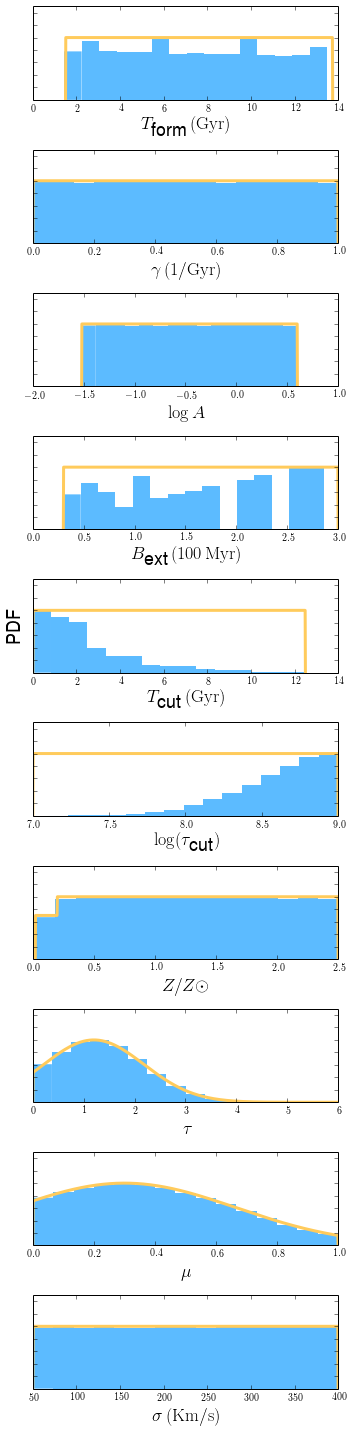

In [6]:
#Plots
labs = [r"$T_{\mbox{form}}\,{\rm (Gyr)}$",
        r"$\gamma\,{\rm (1/Gyr)}$",
        r"$\log{A}$",
        r"$B_{\mbox{ext}}\,{\rm (100\,Myr)}$",
        r"$T_{\mbox{cut}}\,{\rm (Gyr)}$",
        r"$\log(\tau_{\mbox{cut}})$",
        r"$Z/Z\odot$",
        r"$\tau$",
        r"$\mu$",
        r"$\sigma\,{\rm (Km/s)}$"]
kws = ["tform", "gamma", "A", "burstext", "tcut", "taucut", "Z", "tau", "mu", "sigma"]
xs = [np.linspace(1.5, 13.75, 1000),
      np.linspace(0, 1, 1000),
      np.linspace(-1.52, 0.60, 1000),
      np.linspace(0.3, 3.0, 1000),
      np.linspace(0.001, 12.5, 1000),
      np.linspace(7, 9, 1000),
      np.linspace(0.02, 2.5, 1000),
      np.linspace(0, 6, 1000),
      np.linspace(0.0, 1, 1000),
      np.linspace(50, 400, 1000)]
PDFs = [lambda x : ones(1000),
        lambda x : ones(1000),
        lambda x : ones(1000),
        lambda x : ones(1000),
        lambda x : ones(1000),
        lambda x : ones(1000),
        lambda x : np.piecewise(x, [x < 0.2, x > 0.2], [0.7, 1.0]),
        lambda x : st.norm.pdf(x, 1.2, 0.98520478)*0.98520478*np.sqrt(2*np.pi)/2.19,
        lambda x : st.norm.pdf(x, 0.3, 0.36566883)*0.36566883*np.sqrt(2*np.pi)/0.62,
        lambda x : ones(1000)]

fig, axs = subplots(10, 1, figsize=(5, 20))

for i in xrange(axs.size):
    if i==4 or i==5: n, bins, patches = axs[i].hist(catal[kws[i]][catal["trun"]], nb, histtype=ht, lw=2, color=pdf_col, ec=ec)
    else: n, bins, patches = axs[i].hist(catal[kws[i]], nb, histtype=ht, lw=2, color=pdf_col, ec=ec)

    nmax = n.max()
    for patch in patches: patch.set_height(float(patch.get_height()) / nmax)
    
    func = PDFs[i]
    y = func(xs[i])
    y[[0, -1]] = 0.0
    axs[i].plot(xs[i], y / y.max(), lw=3, color=PDF_col)

    if i==4:
        axs[i].set_ylabel("PDF", size=lb_size)
    
    axs[i].set_xlabel(labs[i], size=lb_size)
    axs[i].set_ylim(0, 1.5)
    axs[i].set_yticklabels([])

tight_layout()
savefig("SSAG_props.pdf", bbox_inches="tight")
show()

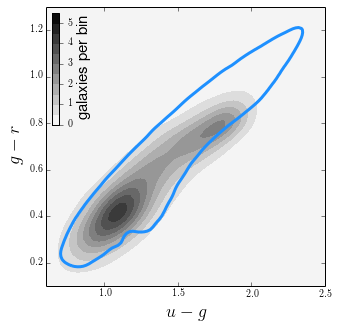

In [7]:
fig = figure(figsize=(5, 5))

xlm = array((0.6, 2.5))
ylm = array((0.1, 1.3))
axs = subplot(111, xlim=xlm, ylim=ylm)
ins = inset_axes(axs, width="2.5%", height="40%", loc=2)

axs.set_xlabel(r"$u-g$", size=lb_size)
axs.set_ylabel(r"$g-r$", size=lb_size)

nx, xi, xf, bsx = nbins(ocolor_x)
ny, yi, yf, bsy = nbins(ocolor_y)

H, xe, ye = histogram2d(ocolor_x, ocolor_y, bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

cont = axs.contourf(xe[:- 1], ye[:- 1], H.T, cmap=cm.gray_r, levels=np.arange(0, 6, 0.5))
cb = colorbar(cont, cax=ins)
cb.set_label(r"galaxies per bin", size=15)

nx, xi, xf, bsx = nbins(lcolor_x)
ny, yi, yf, bsy = nbins(lcolor_y)

H, xe, ye = histogram2d(lcolor_x, lcolor_y, bins=(nx, ny), normed=True)
H = gaussian_filter(H, sigma=2)

axs.contour(xe[:- 1], ye[:- 1], H.T, levels=[0.3], colors=["dodgerblue"], linewidths=3)

ins.tick_params(right=True, left=False, direction="out", labelright="on", labelleft="off")
ins.yaxis.set_label_position("right")

savefig("ccd_sample.pdf", bbox_inches="tight")
show()

In [ ]:
iprops = []

fig, axs = subplots(5, 2, sharey=True, figsize=(5, 10))

axs = squeeze(axs)

for i, prop in enumerate(iprops):
    axs[i].hist([table[prop][color<2.22], table[prop][color>=2.22]], histtype="barstacked", ec="w")